In [75]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cvxpy as cp
import warnings

import os

In [2]:
def generate_evolution(logReturn, allocation, T_rebalancement=-1):
    nb_periods = logReturn.shape[0]
    nb_stocks = logReturn.shape[1]
    
    evolution = logReturn * 0.0
    
    if T_rebalancement == -1:
        # Buy and hold strategy
        evolution = np.exp(np.cumsum(logReturn)) * allocation
    else:
        # Rebalancing strategy
        evolution.iloc[:T_rebalancement, :] = np.exp(np.cumsum(logReturn.iloc[:T_rebalancement, :])) * allocation
        
        for i in range(T_rebalancement, nb_periods, T_rebalancement):
            evolution.iloc[i:i+T_rebalancement, :] = np.exp(np.cumsum(logReturn.iloc[i:i+T_rebalancement, :])) * evolution.iloc[i-1, :].sum() * allocation
        last_period = (nb_periods//T_rebalancement)*T_rebalancement
        evolution.iloc[last_period:, :] = np.exp(np.cumsum(logReturn.iloc[last_period:, :])) * evolution.iloc[last_period-1, :].sum() * allocation
    
    return evolution

Paramètres = {

    "Begin date" :
    "End date" :
    "Returns" :
    "Volatilities" :
    "Correlation matrix" :
    "Allocation" :
    "Rebalancing period" :
}

data_ESG : DataFrame

Contraints = {

    "lists" : ["Min return", "Esg Score min", "", ...]"
    "Value" : [ 0.05, ]
}

Contraints = {
    
    "lists" : ["Sharpe", "Esg Score min", "", ...]"
    "Value" : [ 0, 0.05, 17, ]
}

In [ ]:
class Simulation:
    def __init__(self, nb_scenarios, model, strategie, parametres, rf = 0.02):
        if not isinstance(nb_scenarios, int):
            raise ValueError("nb_scenarios must be an integer")
        if model not in ["BS", "On verra"]:
            raise ValueError("model must be either 'BS' or 'On verra'")
        if strategie not in ["Buy and hold", "Rebalancing"]:
            raise ValueError("strategie must be either 'Buy and hold' or 'Rebalancing")
        self.nb_scenarios = nb_scenarios
        self.model = model
        self.strategie = strategie
        self.parametres = parametres
        self.rf = rf

    def set_dataESG(self, dataESG):
        """""
        pandas.series representing the ESG data for each stock
        columns : 
            - Risque de durabilite
            - Risque exposition
            - Score de Management
            - Risque Carbone
            - Intensite carbonne (Tonnes de CO2)
        """
        self.dataESG = dataESG

    def set_contraints(self, contraints):
        """
        dictionnary representing the type and the value of contraints of the optimization problem

        {
            "List" : example ["Maximal volatilities" ou "Minimal return" ou "Sharpe" , "Minimal durability" ...]
            "Value : example [0, 0.1, ...]
        }
        """
        self.contraints = contraints

    def compute_allocation(self):
        """
        Calculate optimal portfolio allocation based on constraints and ESG data
        """
        # Define objective function based on criteria
        returns = self.parametres["Returns"]
        volatilities = self.parametres["Volatilities"]
        Correlation_matrix = self.parametres["Correlation matrix"]
        covMatrix = np.diag(volatilities) @ Correlation_matrix @ np.diag(volatilities)
        rf = self.rf
        dataESG = self.dataESG

        # Number of assets in portfolio
        nb_stocks = Correlation_matrix.shape[0]
        # Define portfolio weights as optimization variables
        w = cp.Variable(nb_stocks)
        # Define optimization Markowitz problem
        portfolio_return = cp.sum(w@returns)
        portfolio_variance = cp.quad_form(w, covMatrix)
        constraints = [cp.sum(w) == 1, w >= 0]
        
        if "Minimal return" in self.contraints["List"]:
            constraints.append( portfolio_return >= self.contraints["Value"][self.contraints["List"].index("Minimal return")])
            objective = cp.Minimize(portfolio_variance)
        if "Maximal volatility" in self.contraints["List"]:
            constraints.append(portfolio_variance <= (self.contraints["Value"][self.contraints["List"].index("Maximal volatility")]) ** 2)
            objective = cp.Maximize(portfolio_return)
        else:
            objective = cp.Maximize(portfolio_return)

        # Define optimization ESG problem
        for i, criteria in enumerate(self.dataESG.columns):
            if "Maximal " + criteria in self.contraints["List"]:
                posCriteria = self.contraints["List"].index("Maximal " + criteria)
                constraints.append(cp.sum(w * dataESG[criteria]) <= self.contraints["Value"][posCriteria])
            elif "Minimal " + criteria in self.contraints["List"]:
                posCriteria = self.contraints["List"].index("Minimal " + criteria)
                constraints.append(cp.sum(w * dataESG[criteria]) >= self.contraints["Value"][posCriteria])

        # Define optimization problem
        prob = cp.Problem(objective, constraints)
        # Solve optimization problem
        prob.solve()
        # Get optimal portfolio weights
        self.parametres["Allocation"] = w.value

    def generate_scenarios(self):
        nb_scenarios = self.nb_scenarios
        nb_stocks = len(self.parametres["Returns"])
        # Génération des dates excluant les samedis et dimanches
        dates = pd.date_range(start=self.parametres["Begin date"], end=self.parametres["End date"], freq='B')
        nb_periods = len(dates)
        # Calcul du facteur d'ajustement pour les volatilities
        delta_t = dates.to_series().diff().dt.days[1:] / 365.25
        delta_t = np.insert(delta_t, 0, 0)
        adjustment_factor = np.sqrt(delta_t)
        
        if self.model == "BS":
            volatilities = self.parametres["Volatilities"]
            returns = self.parametres["Returns"]
            # Génération de scénarios de log-rendements
            log_returns = np.random.normal(0, 1, (nb_periods, nb_stocks, nb_scenarios))
            cholesky_matrix = np.linalg.cholesky(self.parametres["Correlation matrix"])
            for i in range(self.nb_scenarios):
                log_returns[:, :, i] = log_returns[:, :, i] @ cholesky_matrix.T
            log_returns = log_returns * (volatilities.values[:, None] * adjustment_factor[:, None, None])
            # Ajout du rendement moyen annuel
            mean_returns = (returns.values[:, None] / 256.2305133079848) * delta_t[:, None, None]
            log_returns += mean_returns
            self.scenarios = {f'Scenario {i+1}': pd.DataFrame(log_returns[:, :, i], index=dates, columns=volatilities.index) for i in range(nb_scenarios)}

    def generate_evolutions(self):
        nb_periods = self.scenarios["Scenario 1"].shape[0]
        nb_stocks = self.scenarios["Scenario 1"].shape[0]
        T_rebalancement = self.parametres["Rebalancing period"] if self.strategie == "Rebalancing" else -1
        allocation = self.parametres["Allocation"]
        self.evolutions = {f'Evolution {i+1}' : generate_evolution(self.scenarios[f"Scenario {i+1}"], allocation, T_rebalancement) for i in range(self.nb_scenarios)}



In [4]:
if True :
    # Create dictionary to store dataFrames for the 40 CAC40 companies
    Data10y_dic = {}

    # Get list of files containing 'Data' in the "Data/CAC40 daily 10y"
    directory = "Data/CAC40 daily 10y"
    files = [f for f in os.listdir(directory) if 'Data' in f]
    # Process each file
    for file in files:
        # Get company name (first word before '_')
        company = file.split('_')[0]
        
        # Read the file with tab separator
        df = pd.read_csv(os.path.join(directory, file), sep='\t')
        
        # Convert first column to datetime and set as index
        df.index = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')

        df = df.drop('date', axis=1)  # Remove the original date column
        df = df.dropna(axis=1, how='all') # Drop columns with all NaN values
        
        # Store in dictionary
        Data10y_dic[company] = df

    print(f"Loaded {len(Data10y_dic)} companies' data")

    # Create list of DataFrames with only 'clot' column
    dfs = [df['clot'] for df in Data10y_dic.values()]
    histo_CAC40 = pd.concat(dfs, axis=1, keys=Data10y_dic.keys())
    histo_CAC40 = histo_CAC40.sort_index()

    print(f"Shape of historical data: {histo_CAC40.shape}")
    print("\nFirst few rows:")
    # Drop rows with NaN values
    histo_CAC40_woNaN = histo_CAC40.dropna()
    print(f"Shape after dropping NaN rows: {histo_CAC40_woNaN.shape}")
    data = histo_CAC40_woNaN
    # Calcul du vecteur de rendement moyen annuel
    mu_annuel = np.log((data.iloc[-1, :]/data.iloc[0,:])) / (data.index[-1] - data.index[0]).days * 365.25
    delta_année = data.index.to_series().diff().dt.days.iloc[1:] / 365.25
    deltat_r = pd.DataFrame(delta_année.values[:, None] * mu_annuel.values, columns=mu_annuel.index, index=delta_année.index)
    nb_jour_pan = data.shape[0] / (data.index[-1] - data.index[0]).days * 365.25
    Volatilite_annuel = np.sqrt((np.log((data/data.shift(1)).iloc[1:,:]) - deltat_r).var() * nb_jour_pan)
    mat_correlation = (np.log((data/data.shift(1)).iloc[1:,:]) - deltat_r).corr()

    nb_stocks = 40
    allocations_EW = np.ones(nb_stocks) / nb_stocks

# Import the weights data of CAC40
CAC40_weights_df = pd.read_csv('Data/InfoCAC40.csv', sep=';').set_index('Company')
# Convert string values to float
CAC40_weights = CAC40_weights_df.iloc[0, :].str.replace(',', '.').astype(float).values


Loaded 40 companies' data
Shape of historical data: (2562, 40)

First few rows:
Shape after dropping NaN rows: (1733, 40)


In [64]:
nb_simu = 10
allocation = allocations_EW
allocation = CAC40_weights

parametres_BuyH = {
    "Begin date": '2025-03-10',
    "End date": '2035-03-10',
    "Returns": mu_annuel,
    "Volatilities": Volatilite_annuel,
    "Correlation matrix": mat_correlation,
    "Allocation": allocation,
}
simulation_BuyH = Simulation(nb_scenarios=nb_simu, model="BS", strategie="Buy and hold", parametres=parametres_BuyH)
simulation_BuyH.generate_scenarios()
simulation_BuyH.generate_evolutions()

parametres_Rebal21 = {
    "Begin date": '2025-03-10',
    "End date": '2035-03-10',
    "Returns": mu_annuel,
    "Volatilities": Volatilite_annuel,
    "Correlation matrix": mat_correlation,
    "Allocation": allocation,
    "Rebalancing period": 21
}
simulation_Rebal21 = Simulation(nb_scenarios=nb_simu, model="BS", strategie="Rebalancing", parametres=parametres_Rebal21)
simulation_Rebal21.scenarios = simulation_BuyH.scenarios
simulation_Rebal21.generate_evolutions()

parametres_Rebal5 = {
    "Begin date": '2025-03-10',
    "End date": '2035-03-10',
    "Returns": mu_annuel,
    "Volatilities": Volatilite_annuel,
    "Correlation matrix": mat_correlation,
    "Allocation": allocation,
    "Rebalancing period": 5
}
simulation_Rebal5 = Simulation(nb_scenarios=nb_simu, model="BS", strategie="Rebalancing", parametres=parametres_Rebal5)
simulation_Rebal5.scenarios = simulation_BuyH.scenarios
simulation_Rebal5.generate_evolutions()

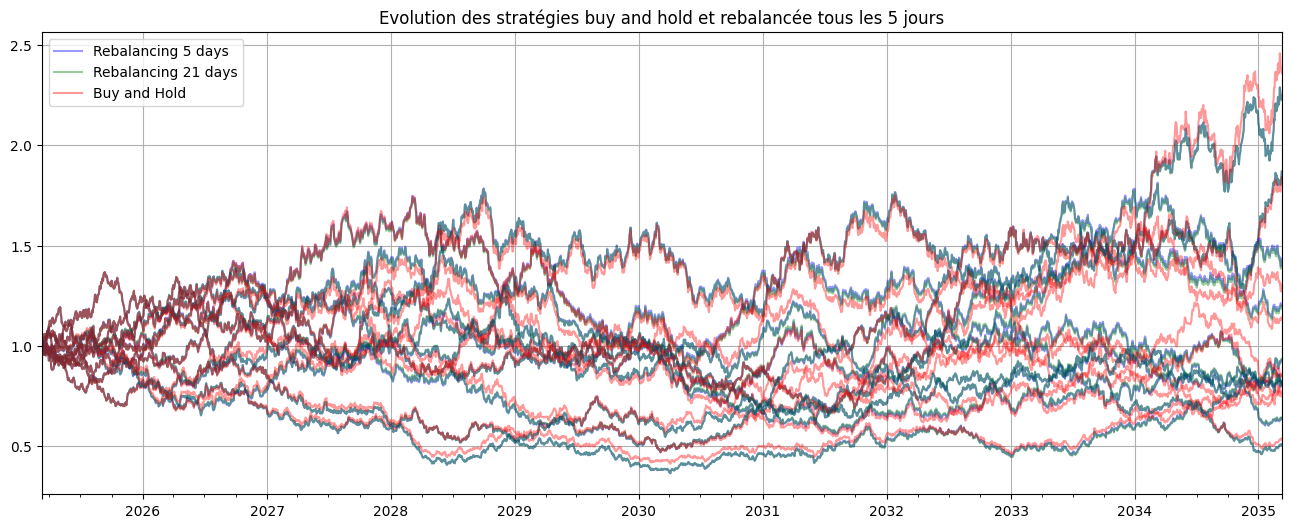

In [68]:
plt.figure(figsize=(16, 6))

lines = []
evolution_rebal5 = simulation_Rebal5.evolutions
evolution_BuyH = simulation_BuyH.evolutions
evolution_rebal21 = simulation_Rebal21.evolutions

for evolution_name, evolution_data in evolution_rebal5.items():
    lines.append(evolution_data.sum(axis=1).plot(color="blue", alpha=0.4, label="Rebalancing 5 days"))
    lines.append(evolution_rebal21[evolution_name].sum(axis=1).plot(color="green", alpha=0.4, label="Rebalancing 21 days"))
    lines.append(evolution_BuyH[evolution_name].sum(axis=1).plot(color="red", alpha=0.4, label="Buy and Hold"))

plt.title("Evolution des stratégies buy and hold et rebalancée tous les 5 jours")
plt.grid()

# Get unique legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()

In [121]:
warnings.filterwarnings('ignore')

parametres_BuyH_sous_constrains = {
    "Begin date": '2025-03-10',
    "End date": '2035-03-10',
    "Returns": mu_annuel,
    "Volatilities": Volatilite_annuel,
    "Correlation matrix": mat_correlation
}
Data_esg = (pd.read_csv('Data/InfoCAC40.csv', sep=';').set_index('Company').iloc[1:, :]).T
#string to float
Data_esg = Data_esg.apply(lambda x: x.str.replace(',', '.').astype(float), axis=1)
simulation_BuyH_sous_constrains = Simulation(nb_scenarios=200, model="BS", strategie="Buy and hold", parametres=parametres_BuyH_sous_constrains)
simulation_BuyH_sous_constrains.set_dataESG(Data_esg)
contraints = {
    "List" : ["Maximal volatility", "Maximal Carbon risk", "Maximal Carbon intensity (Tons of CO2)", "Minimal Score management"],
    "Value" : [0.20, 3.5, 40, 65]
}
simulation_BuyH_sous_constrains.set_contraints(contraints)
simulation_BuyH_sous_constrains.compute_allocation()
simulation_BuyH_sous_constrains.generate_scenarios()
simulation_BuyH_sous_constrains.generate_evolutions()


Minimal Score management : 65
Maximal Carbon risk : 3.5
Maximal Carbon intensity (Tons of CO2) : 40


In [122]:
#print vol et rendement allocation
allocation = simulation_BuyH_sous_constrains.parametres["Allocation"]
returns = parametres_BuyH_sous_constrains["Returns"]
volatilities = parametres_BuyH_sous_constrains["Volatilities"]
Correlation_matrix = parametres_BuyH_sous_constrains["Correlation matrix"]
covMatrix = np.diag(volatilities) @ Correlation_matrix @ np.diag(volatilities)
portfolio_return = allocation @ returns
portfolio_variance = allocation @ covMatrix @ allocation
portfolio_Carbon_risk = allocation @ Data_esg["Carbon risk"]
portfolio_Carbon_intensity = allocation @ Data_esg["Carbon intensity (Tons of CO2)"]
portfolio_score_management = allocation @ Data_esg["Score management"]


#print(f"Allocation: {allocation} \n")
print(f"Portfolio return: {portfolio_return}")
print(f"Portfolio volatility: {np.sqrt(portfolio_variance)}")
print(f"Portfolio Carbon risk: {portfolio_Carbon_risk}")
print(f"Portfolio Carbon intensity: {portfolio_Carbon_intensity}")
print(f"Portfolio Score management: {portfolio_score_management}")


Portfolio return: 0.1720016338087614
Portfolio volatility: 0.20000000016304012
Portfolio Carbon risk: 3.4999973950697996
Portfolio Carbon intensity: 28.481262845041485
Portfolio Score management: 65.16314064406338


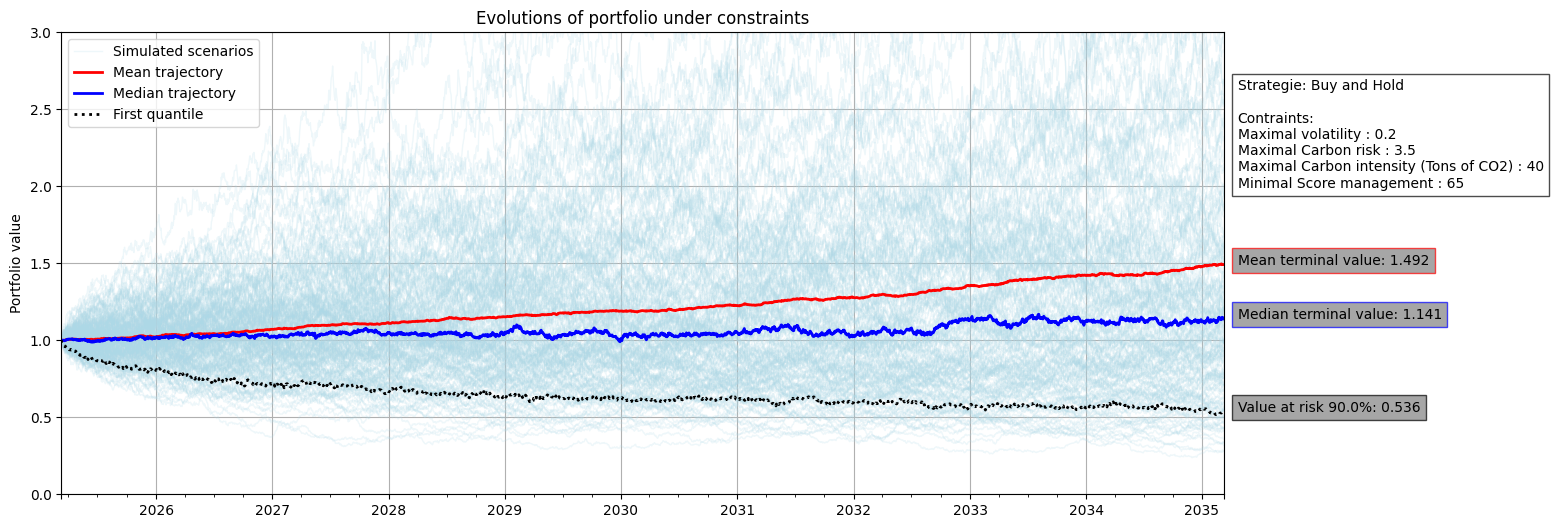

In [ ]:
plt.figure(figsize=(15, 6))
alpha = 0.90

# Plot individual scenarios in light blue
first = True
for evolution_name, evolution_data in simulation_BuyH_sous_constrains.evolutions.items():
    if first:
        evolution_data.sum(axis=1).plot(color='lightBlue', alpha=0.2, linewidth=1, label="Simulated scenarios")
        first = False
    else:
        evolution_data.sum(axis=1).plot(color='lightBlue', alpha=0.2, linewidth=1, label='_nolegend_')

# Calculate and plot mean trajectory in red
mean_evolution = pd.DataFrame({name: data.sum(axis=1) for name, data in simulation_BuyH_sous_constrains.evolutions.items()}).mean(axis=1)
mean_evolution.plot(color='Red', linewidth=2, label='Mean trajectory')

# Calculate and plot median trajectory in dark blue
median_evolution = pd.DataFrame({name: data.sum(axis=1) for name, data in simulation_BuyH_sous_constrains.evolutions.items()}).median(axis=1)
median_evolution.plot(color='blue', linewidth=2, label='Median trajectory')

# Calculate and plot first quantile in black dotted line
VAR_evolution = pd.DataFrame({name: data.sum(axis=1) for name, data in simulation_BuyH_sous_constrains.evolutions.items()}).quantile(1-alpha, axis=1)
VAR_evolution.plot(color='Black', linestyle=':', linewidth=2, label='First quantile')

# Add terminal value annotations
terminal_value = mean_evolution.iloc[-1]
terminal_median = median_evolution.iloc[-1]
terminal_VAR = VAR_evolution.iloc[-1]

contraints = simulation_BuyH_sous_constrains.contraints
txt_contraints = "Contraints:"
for i, contraint in enumerate(contraints["List"]):
    txt_contraints += f"\n{contraint} : {contraints['Value'][i]}"
# If Rebalancing period doesn't exist in parameters, set it to -1 (Buy and Hold)
Rebalancing_period = simulation_BuyH_sous_constrains.parametres.get("Rebalancing period", -1)
txt_strategie = f"Strategie: {f'Rebalancing (T={Rebalancing_period})' if Rebalancing_period != -1 else 'Buy and Hold'}"

plt.annotate(txt_strategie + '\n\n' + txt_contraints, 
            xy=(mean_evolution.index[-1], terminal_value + 0.5),
            xytext=(10, 0), textcoords='offset points',
            bbox=dict(facecolor='White', edgecolor='Black', alpha=0.7))


plt.annotate(f'Mean terminal value: {terminal_value:.3f}', 
            xy=(mean_evolution.index[-1], terminal_value),
            xytext=(10, 0), textcoords='offset points',
            bbox=dict(facecolor='Gray', edgecolor='red', alpha=0.7))

plt.annotate(f'Median terminal value: {terminal_median:.3f}', 
            xy=(median_evolution.index[-1], terminal_median),
            xytext=(10, 0), textcoords='offset points',
            bbox=dict(facecolor='Gray', edgecolor='blue', alpha=0.7))

plt.annotate(f'Value at risk {alpha*100}%: {terminal_VAR:.3f}', 
            xy=(mean_evolution.index[-1], terminal_VAR),
            xytext=(10, 0), textcoords='offset points',
            bbox=dict(facecolor='Gray', edgecolor='black', alpha=0.7))

plt.ylabel('Portfolio value')
plt.ylim(0, 3)
plt.title("Evolutions of portfolio under constraints")
plt.grid()
plt.legend()
plt.show()


In [151]:
# rebalance all 5 days and relax the constraints

parametres_BuyH_sous_constrains2 = {
    "Begin date": '2025-03-10',
    "End date": '2035-03-10',
    "Returns": mu_annuel,
    "Volatilities": Volatilite_annuel,
    "Correlation matrix": mat_correlation,
    "Rebalancing period": 5
}
simulation_BuyH_sous_constrains2 = Simulation(nb_scenarios=200, model="BS", strategie="Rebalancing", parametres=parametres_BuyH_sous_constrains2)
simulation_BuyH_sous_constrains2.set_dataESG(Data_esg)
contraints2 = {
    "List" : ["Maximal volatility", "Maximal Carbon risk", "Maximal Carbon intensity (Tons of CO2)", "Minimal Score management"],
    "Value" : [0.25, 7, 2000, 50]
}
simulation_BuyH_sous_constrains2.set_contraints(contraints2)
simulation_BuyH_sous_constrains2.compute_allocation()
simulation_BuyH_sous_constrains2.generate_scenarios()
simulation_BuyH_sous_constrains2.generate_evolutions()

#print vol et rendement allocation
allocation2 = simulation_BuyH_sous_constrains2.parametres["Allocation"]
portfolio_return2 = allocation2 @ returns
portfolio_variance2 = allocation2 @ covMatrix @ allocation2
portfolio_Carbon_risk2 = allocation2 @ Data_esg["Carbon risk"]
portfolio_Carbon_intensity2 = allocation2 @ Data_esg["Carbon intensity (Tons of CO2)"]
portfolio_score_management2 = allocation2 @ Data_esg["Score management"]


#print(f"Allocation: {allocation} \n")
print(f"Portfolio return: {portfolio_return2}")
print(f"Portfolio volatility: {np.sqrt(portfolio_variance2)}")
print(f"Portfolio Carbon risk: {portfolio_Carbon_risk2}")
print(f"Portfolio Carbon intensity: {portfolio_Carbon_intensity2}")
print(f"Portfolio Score management: {portfolio_score_management2}")

Minimal Score management : 50
Maximal Carbon risk : 7
Maximal Carbon intensity (Tons of CO2) : 2000
Portfolio return: 0.2057332114479297
Portfolio volatility: 0.25000000000679423
Portfolio Carbon risk: 1.4856156095476294
Portfolio Carbon intensity: 4.166176850019991
Portfolio Score management: 65.07799117090094


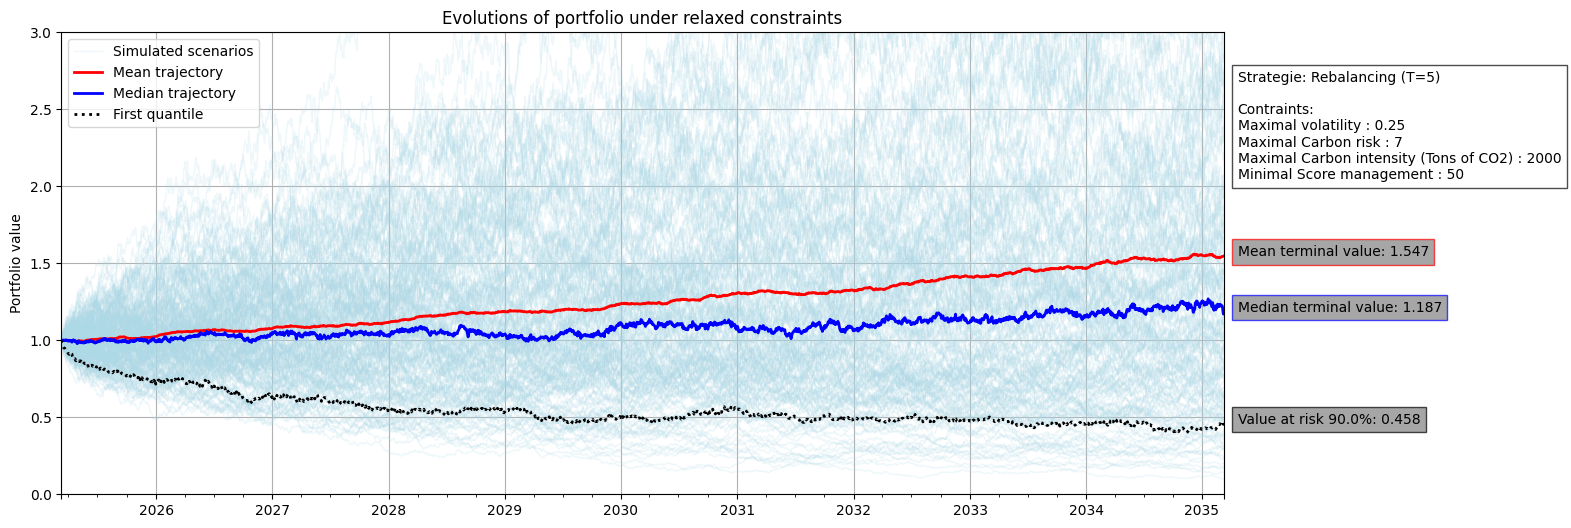

In [152]:
plt.figure(figsize=(15, 6))
alpha = 0.90

# Plot individual scenarios in light blue
first = True
for evolution_name, evolution_data in simulation_BuyH_sous_constrains2.evolutions.items():
    if first:
        evolution_data.sum(axis=1).plot(color='lightBlue', alpha=0.2, linewidth=1, label="Simulated scenarios")
        first = False
    else:
        evolution_data.sum(axis=1).plot(color='lightBlue', alpha=0.2, linewidth=1, label='_nolegend_')

# Calculate and plot mean trajectory in red
mean_evolution = pd.DataFrame({name: data.sum(axis=1) for name, data in simulation_BuyH_sous_constrains2.evolutions.items()}).mean(axis=1)
mean_evolution.plot(color='Red', linewidth=2, label='Mean trajectory')

# Calculate and plot median trajectory in dark blue
median_evolution = pd.DataFrame({name: data.sum(axis=1) for name, data in simulation_BuyH_sous_constrains2.evolutions.items()}).median(axis=1)
median_evolution.plot(color='blue', linewidth=2, label='Median trajectory')

# Calculate and plot first quantile in black dotted line
VAR_evolution = pd.DataFrame({name: data.sum(axis=1) for name, data in simulation_BuyH_sous_constrains2.evolutions.items()}).quantile(1-alpha, axis=1)
VAR_evolution.plot(color='Black', linestyle=':', linewidth=2, label='First quantile')

# Add terminal value annotations
terminal_value = mean_evolution.iloc[-1]
terminal_median = median_evolution.iloc[-1]
terminal_VAR = VAR_evolution.iloc[-1]

contraints = simulation_BuyH_sous_constrains2.contraints
txt_contraints = "Contraints:"
for i, contraint in enumerate(contraints["List"]):
    txt_contraints += f"\n{contraint} : {contraints['Value'][i]}"
# If Rebalancing period doesn't exist in parameters, set it to -1 (Buy and Hold)
Rebalancing_period = simulation_BuyH_sous_constrains2.parametres.get("Rebalancing period", -1)
txt_strategie = f"Strategie: {f'Rebalancing (T={Rebalancing_period})' if Rebalancing_period != -1 else 'Buy and Hold'}"

plt.annotate(txt_strategie + '\n\n' + txt_contraints, 
            xy=(mean_evolution.index[-1], terminal_value + 0.5),
            xytext=(10, 0), textcoords='offset points',
            bbox=dict(facecolor='White', edgecolor='Black', alpha=0.7))


plt.annotate(f'Mean terminal value: {terminal_value:.3f}', 
            xy=(mean_evolution.index[-1], terminal_value),
            xytext=(10, 0), textcoords='offset points',
            bbox=dict(facecolor='Gray', edgecolor='red', alpha=0.7))

plt.annotate(f'Median terminal value: {terminal_median:.3f}', 
            xy=(median_evolution.index[-1], terminal_median),
            xytext=(10, 0), textcoords='offset points',
            bbox=dict(facecolor='Gray', edgecolor='blue', alpha=0.7))

plt.annotate(f'Value at risk {alpha*100}%: {terminal_VAR:.3f}', 
            xy=(mean_evolution.index[-1], terminal_VAR),
            xytext=(10, 0), textcoords='offset points',
            bbox=dict(facecolor='Gray', edgecolor='black', alpha=0.7))

plt.ylabel('Portfolio value')
plt.ylim(0, 3)
plt.title("Evolutions of portfolio under relaxed constraints")
plt.grid()
plt.legend()
plt.show()